In [0]:
# Load libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
from sklearn import metrics
import sys
from google.colab import drive

### Model performance metric ftn

In [0]:
def get_accuracy(probs, labels, accu_thre=0.5):
    pred_labels = np.zeros(probs.shape)
    pred_labels[probs >= accu_thre] = 1.0
    accuracy = metrics.accuracy_score(labels, pred_labels)
    return accuracy

def get_ks_statistics(probs, labels):
    probs_pos = probs[labels == 1]
    probs_neg = probs[labels == 0]
    ks, ks_p_value = stats.ks_2samp(probs_pos, probs_neg)
    return ks, ks_p_value

def get_auc_ar(probs, labels):
    auc = metrics.roc_auc_score(labels, probs)
    ar = auc * 2 - 1
    return auc, ar

class Performances:
    def __init__(self, probs, labels, accu_thre=0.5):
        accuracy = get_accuracy(probs, labels, accu_thre=accu_thre)
        ks, ks_p_value = get_ks_statistics(probs, labels)
        auc, ar = get_auc_ar(probs, labels)
        self.accuracy = accuracy
        self.ks = ks * 100  # percent
        self.ks_p_value = ks_p_value
        self.auc = auc * 100  # percent
        self.ar = ar * 100  # percent
        
perf_dict = {'ar': 10, 'ks': 20, 'accuracy': 50, 'prob': list()}

### Data load : binned datset

In [4]:
# 구글 드라이브 접근 권한 획득
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Set paths
data_rootpath = r'/content/gdrive/My Drive/ML_basic/ML_basic_dataset/model_data'

# Read data
X_train_df = pd.read_csv(os.path.join(data_rootpath, 'train_bin_X.csv'), index_col=False)
X_valid_df = pd.read_csv(os.path.join(data_rootpath, 'valid_bin_X.csv'), index_col=False)
X_test_df = pd.read_csv(os.path.join(data_rootpath, 'test_bin_X.csv'), index_col=False)

y_train_df = pd.read_csv(os.path.join(data_rootpath, 'train_y.csv'), index_col=False)
y_valid_df = pd.read_csv(os.path.join(data_rootpath, 'valid_y.csv'), index_col=False)
y_test_df = pd.read_csv(os.path.join(data_rootpath, 'test_y.csv'), index_col=False)

In [7]:
X_train_df.shape

(117736, 15)

In [6]:
X_train_df.head()

Unnamed: 0       bc_util  ...             dti mo_sin_rcnt_tl
0      837878  (83.1, 87.4]  ...   (17.65, 18.8]     (3.0, 4.0]
1     1514793  (94.9, 97.9]  ...    (7.31, 9.04]     (3.0, 4.0]
2     1008721  (50.0, 55.0]  ...  (27.52, 29.67]     (3.0, 4.0]
3      661505  (94.9, 97.9]  ...  (25.65, 27.52]     (6.0, 7.0]
4     1387661  (91.4, 94.9]  ...   (9.04, 10.53]     (2.0, 3.0]

[5 rows x 15 columns]

In [0]:
# index 설정
def set_index_and_sort(df):
    df.set_index('Unnamed: 0', inplace=True, drop=True, verify_integrity=True)
    df.sort_index(inplace=True)
    return df

In [0]:
X_train_df = set_index_and_sort(X_train_df)
X_valid_df = set_index_and_sort(X_valid_df)
X_test_df = set_index_and_sort(X_test_df)

In [0]:
y_train_df = set_index_and_sort(y_train_df)
y_valid_df = set_index_and_sort(y_valid_df)
y_test_df = set_index_and_sort(y_test_df)

In [11]:
X_train_df.head()

bc_util           annual_inc  ...             dti mo_sin_rcnt_tl
Unnamed: 0                                     ...                               
930         (27.5, 33.6]  (94000.0, 100000.0]  ...  (10.53, 11.83]    (-inf, 1.0]
1104        (39.3, 44.7]   (47000.0, 50000.0]  ...  (10.53, 11.83]   (10.0, 12.0]
1224         (0.4, 11.8]   (43000.0, 47000.0]  ...  (14.22, 15.37]    (-inf, 1.0]
1875        (55.0, 60.0]   (47000.0, 50000.0]  ...   (17.65, 18.8]   (10.0, 12.0]
2787         (-inf, 0.4]   (35000.0, 40000.0]  ...    (7.31, 9.04]     (6.0, 7.0]

[5 rows x 14 columns]

### Dummy !

In [0]:
X_train_dummy_df = pd.get_dummies(X_train_df, drop_first = True, dtype = np.int32)
X_valid_dummy_df = pd.get_dummies(X_valid_df, drop_first = True, dtype = np.int32)
X_test_dummy_df = pd.get_dummies(X_test_df, drop_first = True, dtype = np.int32)

In [13]:
X_train_df.head()

bc_util           annual_inc  ...             dti mo_sin_rcnt_tl
Unnamed: 0                                     ...                               
930         (27.5, 33.6]  (94000.0, 100000.0]  ...  (10.53, 11.83]    (-inf, 1.0]
1104        (39.3, 44.7]   (47000.0, 50000.0]  ...  (10.53, 11.83]   (10.0, 12.0]
1224         (0.4, 11.8]   (43000.0, 47000.0]  ...  (14.22, 15.37]    (-inf, 1.0]
1875        (55.0, 60.0]   (47000.0, 50000.0]  ...   (17.65, 18.8]   (10.0, 12.0]
2787         (-inf, 0.4]   (35000.0, 40000.0]  ...    (7.31, 9.04]     (6.0, 7.0]

[5 rows x 14 columns]

In [14]:
X_train_dummy_df.head()

bc_util_(0.4, 11.8]  ...  mo_sin_rcnt_tl_(9.0, 10.0]
Unnamed: 0                       ...                            
930                           0  ...                           0
1104                          0  ...                           0
1224                          1  ...                           0
1875                          0  ...                           0
2787                          0  ...                           0

[5 rows x 196 columns]

In [15]:
X_train_df.shape

(117736, 14)

In [16]:
X_train_dummy_df.shape

(117736, 196)

In [0]:
from sklearn.linear_model import LogisticRegression

In [18]:
import sklearn
sklearn.__version__

'0.21.3'

### No penalty term Logistic regression

[logistic_regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [0]:
model = LogisticRegression(penalty='l2', 
                           solver='liblinear', 
                           C = 1)

In [20]:
# Fitting
model.fit(X_train_dummy_df, y_train_df)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Predict probability
prob_tr = model.predict_proba(X_train_dummy_df)
# prob_valid = model.predict_proba(X_valid_dummy_df)
prob_test= model.predict_proba(X_test_dummy_df)

In [0]:
# Compute KS/AR
result_train = Performances(prob_tr[:, 1], y_train_df['Y'])
# result_valid = Performances(prob_valid[:, 1], y_valid_df['Y'])
result_test = Performances(prob_test[:, 1], y_test_df['Y'])

In [26]:
result_train.ks

23.263097485096658

In [27]:
print("Training KS : {:.5f}, / AR : {:.5f}".format(result_train.ks, result_train.ar))
# print("Validation KS : {:.5f}, / AR : {:.5f}".format(result_valid.ks, result_valid.ar))
print("Test KS : {:.5f}, / AR : {:.5f}".format(result_test.ks, result_test.ar))

Training KS : 23.26310, / AR : 32.68116
Test KS : 22.92272, / AR : 31.54852


In [0]:
# KS plotting ftn
def KS_compute_with_plot(prob, data_type):

    GOOD_p = prob[data_type == 0]
    BAD_p = prob[data_type == 1]

    ks = stats.ks_2samp(GOOD_p[:,1], BAD_p[:,1])

    ecdf_0 = sm.distributions.ECDF(GOOD_p[:,1])
    ecdf_1 = sm.distributions.ECDF(BAD_p[:,1])
    plt.plot(ecdf_0.x, ecdf_0.y, label="GOOD")
    plt.plot(ecdf_1.x, ecdf_1.y, label='BAD')
    # plt.xlim(0, 0.3)

    plt.ylabel('CDF')
    plt.xlabel('p')
    plt.title('KS')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    return (ks[0])

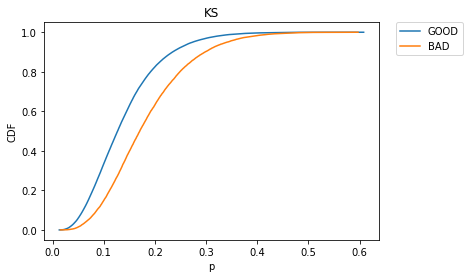

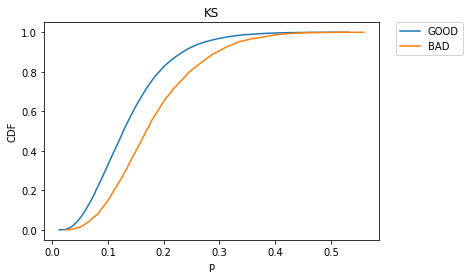

0.2292271645457738

In [29]:
# KS plotting
KS_compute_with_plot(prob=prob_tr, data_type=y_train_df['Y'])
# KS_compute_with_plot(prob=prob_valid, data_type=y_valid_df['Y'])
KS_compute_with_plot(prob=prob_test, data_type=y_test_df['Y'])

### L2 regularization

In [30]:
l2_lambda = np.linspace(0.1, 1, num = 10).tolist()
l2_lambda

[0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

In [0]:
l2_lambda = [0.001, 0.005, 0.01, 0.05] + l2_lambda

In [32]:
l2_lambda

[0.001,
 0.005,
 0.01,
 0.05,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

In [0]:
contents = {'l2_lambda', 
            'ks_trn', 'ks_val', 'ks_tst', 
            'ar_trn', 'ar_val', 'ar_tst', 
            'iv_trn', 'iv_val', 'iv_tst'}

In [0]:
performance_df = pd.DataFrame(columns = contents)
performance_df = performance_df[['l2_lambda', 
            'ks_trn', 'ks_val', 'ks_tst', 
            'ar_trn', 'ar_val', 'ar_tst']]

In [35]:
l2_result_dict = dict()
for l in l2_lambda:
    
    model = LogisticRegression(penalty='l2', 
                           solver='liblinear', 
                           C = l)
    
    # Fitting
    model.fit(X_train_dummy_df, y_train_df)
    
    # Predict probability
    prob_tr = model.predict_proba(X_train_dummy_df)
#     prob_valid = model.predict_proba(X_valid_dummy_df)
    prob_test= model.predict_proba(X_test_dummy_df)
    
    # Compute KS/AR
    result_train = Performances(prob_tr[:, 1], y_train_df['Y'])
#     result_valid = Performances(prob_valid[:, 1], y_valid_df['Y'])
    result_test = Performances(prob_test[:, 1], y_test_df['Y'])
    
    # update_dict
    update_dict = {'l2_lambda' : l,
                     'ks_trn' : result_train.ks,
#                      'ks_val' : result_valid.ks,
                     'ks_tst' : result_test.ks,
                     'ar_trn' : result_train.ar,
#                      'ar_val' : result_valid.ar,
                     'ar_tst' : result_test.ar}
    performance_df = performance_df.append(update_dict, ignore_index=True)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [0]:
performance_df

l2_lambda     ks_trn  ks_val     ks_tst     ar_trn  ar_val     ar_tst
0       0.001  22.003611     NaN  21.168746  30.259502     NaN  29.406723
1       0.005  22.880092     NaN  22.084545  31.879403     NaN  30.954848
2       0.010  23.000383     NaN  22.324745  32.211309     NaN  31.241959
3       0.050  23.251955     NaN  22.865638  32.579772     NaN  31.527923
4       0.100  23.302244     NaN  22.930725  32.634200     NaN  31.554187
5       0.200  23.279694     NaN  22.853582  32.660502     NaN  31.557787
6       0.300  23.288027     NaN  22.906009  32.669522     NaN  31.556251
7       0.400  23.288759     NaN  22.902869  32.673413     NaN  31.554024
8       0.500  23.283113     NaN  22.925338  32.676015     NaN  31.551845
9       0.600  23.271273     NaN  22.976022  32.677477     NaN  31.550938
10      0.700  23.290442     NaN  22.983886  32.679189     NaN  31.550451
11      0.800  23.294417     NaN  22.945488  32.679455     NaN  31.549224
12      0.900  23.269058     NaN  22.940605  32.680827     NaN  31.548836
13      1.000  23.263097     NaN  22.922716  32.681160     NaN  31.548518

In [0]:
result_path = r'C:\Users\w10\Code\교육'

In [0]:
performance_df.to_csv(os.path.join(result_path, 'Logistic_result_selected.csv'), index = False)